In [3]:
import pyforest
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import flaml
from catboost import CatBoostRegressor
import mlflow

In [26]:
df  = pd.read_csv('/Users/karanam.rama/Downloads/house_price_pred_repo/datas/raw/house_pred_raw_data.csv')
df['MSSubClass'] =df['MSSubClass'].astype('str')
# df['price_per_sqft'] = df['SalePrice']/df['LotArea']
print('shape of the dataframe',df.shape)
print('data frame head')
df.head()

<IPython.core.display.Javascript object>

shape of the dataframe (1460, 81)
data frame head


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [27]:
df['Fence']=df['Fence'].fillna('NA')
df['PoolQC'] = df['PoolQC'].fillna('NA')
df['MiscFeature'] = df['MiscFeature'].fillna('NA')
df['Alley'] = df['Alley'].fillna('NA')
df['Fence'] = df['Fence'].fillna('NA')
df['FireplaceQu'] = df['FireplaceQu'].fillna('NA')
df['LotFrontage'] = df['LotFrontage'].fillna(0)

ndf = pd.DataFrame(df.isnull().mean())
ndf.columns = ['null_mean']
ndf = ndf[ndf['null_mean']>0]
ndf['column_name'] = ndf.index


num_list = df[ndf['column_name']].select_dtypes(include=['number']).columns
obj_list = df[ndf['column_name']].select_dtypes(exclude=['number']).columns

# replacing null of int type columns with their mean values
df[num_list] = SimpleImputer(strategy='mean').fit_transform(df[num_list])

# replacing null of object type columns with the most frequent category
df[obj_list] = SimpleImputer(strategy='most_frequent').fit_transform(df[obj_list])

df.set_index(['Id'],inplace = True)

x = df.drop('SalePrice',axis = 1)
y = df['SalePrice']
all_columns = x.columns
cat_columns = x.select_dtypes(include=['object']).columns
num_columns = x.select_dtypes(exclude=['object']).columns

# creating a new data frame with numerical columns only
num_x = x[num_columns]

# creating a new data frame with categorical columns only
ohe = OneHotEncoder()
data = ohe.fit_transform(x[cat_columns])
cat_x =  pd.DataFrame(data.todense(),columns =ohe.get_feature_names(cat_columns),index = x.index )


# joining the both dataframes 

final_x = num_x.join(cat_x,how='inner')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
# from pandas_profiling import ProfileReport
# rep = ProfileReport(df,title = 'house price prediction data profile report')
# rep.to_file('house_price_report.html')

Summarize dataset:   0%|          | 0/94 [00:00<?, ?it/s]

/Users/karanam.rama/opt/anaconda3/lib/python3.8/site-packages/pandas_profiling/model/correlations.py:146: UserWarning:

There was an attempt to calculate the cramers correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"cramers": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/pandas-profiling/pandas-profiling/issues
(include the error message: 'No data; `observed` has size 0.')



Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [28]:
x_train,x_test,y_train,y_test = train_test_split(final_x,y,random_state=42)

In [48]:
lr = LinearRegression()
lr.fit(x_train,y_train)
y_pred = lr.predict(x_test)
rmse = mean_squared_error(y_test,y_pred,squared=False)
mse = mean_squared_error(y_test,y_pred,squared=True)
mae = mean_absolute_error(y_test,y_pred)
explained_variance_score = sklearn.metrics.explained_variance_score(y_test,y_pred)
r2_score = sklearn.metrics.r2_score(y_test,y_pred)
print('rmse ', rmse)
print('mse ', mse)
print('mae ', mae)
print('explained_variance_score',explained_variance_score)
print('r2_score',r2_score)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

rmse  64650.33211389758
mse  4179665442.4372573
mae  20715.610938675498
explained_variance_score 0.40598525324761103
r2_score 0.40335745201112594


In [33]:
xgbr = XGBRegressor()
xgbr.fit(x_train,y_train)
y_pred = xgbr.predict(x_test)
rmse = mean_squared_error(y_test,y_pred,squared=False)
mse = mean_squared_error(y_test,y_pred,squared=True)
mae = mean_absolute_error(y_test,y_pred)
explained_variance_score = sklearn.metrics.explained_variance_score(y_test,y_pred)
r2 = sklearn.metrics.r2_score(y_test,y_pred)
print('rmse ', rmse)
print('mse ', mse)
print('mae ', mae)
print('explained_variance_score',explained_variance_score)
print('r2',r2)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

rmse  28749.9264034368
mse  826558268.2030324
mae  17307.70959974315
explained_variance_score 0.8826173703717831
r2 0.8820097354695557


In [34]:
lgbmr = LGBMRegressor()
lgbmr.fit(x_train,y_train)
y_pred = lgbmr.predict(x_test)
rmse = mean_squared_error(y_test,y_pred,squared=False)
mse = mean_squared_error(y_test,y_pred,squared=True)
mae = mean_absolute_error(y_test,y_pred)
explained_variance_score = sklearn.metrics.explained_variance_score(y_test,y_pred)
r2 = sklearn.metrics.r2_score(y_test,y_pred)
print('rmse ', rmse)
print('mse ', mse)
print('mae ', mae)
print('explained_variance_score',explained_variance_score)
print('r2',r2)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

rmse  27186.065196255946
mse  739082140.8550789
mae  16585.49614741556
explained_variance_score 0.8947592556636934
r2 0.8944968544095463


In [35]:
cbr = CatBoostRegressor()
cbr.fit(x_train,y_train)
y_pred = lgbmr.predict(x_test)

Learning rate set to 0.039666
0:	learn: 75982.9358961	total: 3.89ms	remaining: 3.89s
1:	learn: 74131.3019023	total: 7.28ms	remaining: 3.63s
2:	learn: 72313.4477312	total: 10.9ms	remaining: 3.63s
3:	learn: 70678.8894654	total: 14ms	remaining: 3.47s
4:	learn: 69036.1173217	total: 17.2ms	remaining: 3.41s
5:	learn: 67465.1978709	total: 20.5ms	remaining: 3.4s
6:	learn: 65871.2024988	total: 23.3ms	remaining: 3.31s
7:	learn: 64387.6124979	total: 26.3ms	remaining: 3.26s
8:	learn: 62891.3902830	total: 29.7ms	remaining: 3.27s
9:	learn: 61643.3476881	total: 32.4ms	remaining: 3.21s
10:	learn: 60256.3256465	total: 35.4ms	remaining: 3.18s
11:	learn: 58935.1359883	total: 38.2ms	remaining: 3.14s
12:	learn: 57656.5061213	total: 40.9ms	remaining: 3.1s
13:	learn: 56526.6004755	total: 43.5ms	remaining: 3.06s
14:	learn: 55468.4195893	total: 46ms	remaining: 3.02s
15:	learn: 54490.9916602	total: 48.8ms	remaining: 3s
16:	learn: 53450.7464291	total: 51.4ms	remaining: 2.97s
17:	learn: 52480.6338954	total: 54.1m

198:	learn: 17436.4600731	total: 568ms	remaining: 2.29s
199:	learn: 17421.0500870	total: 571ms	remaining: 2.28s
200:	learn: 17388.4499425	total: 573ms	remaining: 2.28s
201:	learn: 17365.9756513	total: 576ms	remaining: 2.28s
202:	learn: 17323.0698156	total: 579ms	remaining: 2.27s
203:	learn: 17278.8507392	total: 582ms	remaining: 2.27s
204:	learn: 17214.7039195	total: 584ms	remaining: 2.27s
205:	learn: 17168.2898504	total: 588ms	remaining: 2.26s
206:	learn: 17135.9952703	total: 591ms	remaining: 2.27s
207:	learn: 17095.1280907	total: 594ms	remaining: 2.26s
208:	learn: 17043.3958104	total: 597ms	remaining: 2.26s
209:	learn: 17020.4757918	total: 599ms	remaining: 2.25s
210:	learn: 16974.0416944	total: 602ms	remaining: 2.25s
211:	learn: 16942.2981024	total: 604ms	remaining: 2.25s
212:	learn: 16924.0175830	total: 607ms	remaining: 2.24s
213:	learn: 16897.5587232	total: 611ms	remaining: 2.24s
214:	learn: 16881.1418957	total: 613ms	remaining: 2.24s
215:	learn: 16841.6854889	total: 616ms	remaining

346:	learn: 13237.8082910	total: 950ms	remaining: 1.79s
347:	learn: 13214.9790797	total: 952ms	remaining: 1.78s
348:	learn: 13199.3368070	total: 955ms	remaining: 1.78s
349:	learn: 13164.9820839	total: 958ms	remaining: 1.78s
350:	learn: 13155.7354156	total: 960ms	remaining: 1.77s
351:	learn: 13132.6511481	total: 963ms	remaining: 1.77s
352:	learn: 13129.0393280	total: 966ms	remaining: 1.77s
353:	learn: 13105.0990392	total: 969ms	remaining: 1.77s
354:	learn: 13084.5102826	total: 971ms	remaining: 1.76s
355:	learn: 13067.2103167	total: 974ms	remaining: 1.76s
356:	learn: 13046.9754912	total: 977ms	remaining: 1.76s
357:	learn: 13020.1133342	total: 980ms	remaining: 1.76s
358:	learn: 12988.4003832	total: 983ms	remaining: 1.75s
359:	learn: 12975.5991277	total: 986ms	remaining: 1.75s
360:	learn: 12955.5378779	total: 989ms	remaining: 1.75s
361:	learn: 12944.6440600	total: 991ms	remaining: 1.75s
362:	learn: 12925.8598696	total: 994ms	remaining: 1.74s
363:	learn: 12897.3650151	total: 997ms	remaining

545:	learn: 9842.4093451	total: 1.49s	remaining: 1.24s
546:	learn: 9829.7626126	total: 1.49s	remaining: 1.24s
547:	learn: 9817.5379999	total: 1.5s	remaining: 1.24s
548:	learn: 9813.2589114	total: 1.5s	remaining: 1.23s
549:	learn: 9800.4626631	total: 1.5s	remaining: 1.23s
550:	learn: 9780.4746940	total: 1.5s	remaining: 1.23s
551:	learn: 9770.4900226	total: 1.51s	remaining: 1.22s
552:	learn: 9756.3275774	total: 1.51s	remaining: 1.22s
553:	learn: 9745.0378381	total: 1.51s	remaining: 1.22s
554:	learn: 9732.0278732	total: 1.52s	remaining: 1.22s
555:	learn: 9719.9574672	total: 1.52s	remaining: 1.21s
556:	learn: 9715.6852150	total: 1.52s	remaining: 1.21s
557:	learn: 9702.6273885	total: 1.53s	remaining: 1.21s
558:	learn: 9693.0221869	total: 1.53s	remaining: 1.21s
559:	learn: 9668.1257457	total: 1.53s	remaining: 1.2s
560:	learn: 9655.1111150	total: 1.53s	remaining: 1.2s
561:	learn: 9649.8439119	total: 1.54s	remaining: 1.2s
562:	learn: 9638.4180511	total: 1.54s	remaining: 1.2s
563:	learn: 9619.4

752:	learn: 7423.5847564	total: 2.06s	remaining: 677ms
753:	learn: 7411.1284649	total: 2.06s	remaining: 674ms
754:	learn: 7404.4240064	total: 2.07s	remaining: 671ms
755:	learn: 7388.7888288	total: 2.07s	remaining: 668ms
756:	learn: 7379.5353368	total: 2.07s	remaining: 666ms
757:	learn: 7367.8048973	total: 2.08s	remaining: 663ms
758:	learn: 7356.5402120	total: 2.08s	remaining: 660ms
759:	learn: 7340.7131271	total: 2.08s	remaining: 657ms
760:	learn: 7330.0133373	total: 2.08s	remaining: 655ms
761:	learn: 7316.0786617	total: 2.09s	remaining: 652ms
762:	learn: 7311.3613097	total: 2.09s	remaining: 649ms
763:	learn: 7301.3715798	total: 2.09s	remaining: 646ms
764:	learn: 7289.7920616	total: 2.1s	remaining: 644ms
765:	learn: 7280.5967825	total: 2.1s	remaining: 641ms
766:	learn: 7269.6610722	total: 2.1s	remaining: 638ms
767:	learn: 7266.0838920	total: 2.1s	remaining: 636ms
768:	learn: 7253.6217646	total: 2.11s	remaining: 633ms
769:	learn: 7244.8624672	total: 2.11s	remaining: 630ms
770:	learn: 72

973:	learn: 5758.7622999	total: 2.64s	remaining: 70.4ms
974:	learn: 5753.9790250	total: 2.64s	remaining: 67.7ms
975:	learn: 5747.9576666	total: 2.64s	remaining: 65ms
976:	learn: 5744.2126501	total: 2.64s	remaining: 62.2ms
977:	learn: 5741.0518518	total: 2.65s	remaining: 59.5ms
978:	learn: 5737.2155678	total: 2.65s	remaining: 56.8ms
979:	learn: 5731.5344002	total: 2.65s	remaining: 54.1ms
980:	learn: 5716.9984842	total: 2.65s	remaining: 51.4ms
981:	learn: 5712.9525229	total: 2.66s	remaining: 48.7ms
982:	learn: 5707.8037274	total: 2.66s	remaining: 46ms
983:	learn: 5705.9472571	total: 2.66s	remaining: 43.3ms
984:	learn: 5702.2143996	total: 2.67s	remaining: 40.6ms
985:	learn: 5698.1063300	total: 2.67s	remaining: 37.9ms
986:	learn: 5686.5782755	total: 2.67s	remaining: 35.2ms
987:	learn: 5678.6847576	total: 2.67s	remaining: 32.5ms
988:	learn: 5676.5385990	total: 2.68s	remaining: 29.8ms
989:	learn: 5670.0938496	total: 2.68s	remaining: 27.1ms
990:	learn: 5664.9261863	total: 2.68s	remaining: 24.

In [36]:
rmse = mean_squared_error(y_test,y_pred,squared=False)
mse = mean_squared_error(y_test,y_pred,squared=True)
mae = mean_absolute_error(y_test,y_pred)
explained_variance_score = sklearn.metrics.explained_variance_score(y_test,y_pred)
r2 = sklearn.metrics.r2_score(y_test,y_pred)
print('rmse ', rmse)
print('mse ', mse)
print('mae ', mae)
print('explained_variance_score',explained_variance_score)
print('r2',r2)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

rmse  27186.065196255946
mse  739082140.8550789
mae  16585.49614741556
explained_variance_score 0.8947592556636934
r2 0.8944968544095463


In [37]:
from flaml import AutoML
automl = AutoML()
automl_settings = {"time_budget" : 100,"metric" :  'rmse', "task":'regression',"eval_method" : 'cv'}
automl.fit(x_train,y_train,**automl_settings) 

[flaml.automl: 08-10 12:23:52] {1102} INFO - Evaluation method: cv
[flaml.automl: 08-10 12:23:52] {630} INFO - Using RepeatedKFold
[flaml.automl: 08-10 12:23:52] {1123} INFO - Minimizing error metric: 1-r2
[flaml.automl: 08-10 12:23:52] {1143} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree']
[flaml.automl: 08-10 12:23:52] {1210} INFO - iteration 0, current learner lgbm
[flaml.automl: 08-10 12:23:52] {1361} INFO -  at 0.4s,	best lgbm's error=0.6541,	best lgbm's error=0.6541
[flaml.automl: 08-10 12:23:52] {1210} INFO - iteration 1, current learner lgbm
[flaml.automl: 08-10 12:23:52] {1361} INFO -  at 0.6s,	best lgbm's error=0.6541,	best lgbm's error=0.6541
[flaml.automl: 08-10 12:23:52] {1210} INFO - iteration 2, current learner lgbm


Finished loading model, total used 4 iterations
Finished loading model, total used 4 iterations


[flaml.automl: 08-10 12:23:52] {1361} INFO -  at 0.8s,	best lgbm's error=0.3973,	best lgbm's error=0.3973
[flaml.automl: 08-10 12:23:52] {1210} INFO - iteration 3, current learner lgbm
[flaml.automl: 08-10 12:23:52] {1361} INFO -  at 1.0s,	best lgbm's error=0.3090,	best lgbm's error=0.3090
[flaml.automl: 08-10 12:23:52] {1210} INFO - iteration 4, current learner lgbm


Finished loading model, total used 4 iterations
Finished loading model, total used 4 iterations


[flaml.automl: 08-10 12:23:53] {1361} INFO -  at 1.1s,	best lgbm's error=0.3090,	best lgbm's error=0.3090
[flaml.automl: 08-10 12:23:53] {1210} INFO - iteration 5, current learner lgbm


Finished loading model, total used 4 iterations


[flaml.automl: 08-10 12:23:53] {1361} INFO -  at 1.4s,	best lgbm's error=0.2715,	best lgbm's error=0.2715
[flaml.automl: 08-10 12:23:53] {1210} INFO - iteration 6, current learner xgboost
[flaml.automl: 08-10 12:23:53] {1361} INFO -  at 1.6s,	best xgboost's error=3.0668,	best lgbm's error=0.2715
[flaml.automl: 08-10 12:23:53] {1210} INFO - iteration 7, current learner lgbm


Finished loading model, total used 4 iterations


[flaml.automl: 08-10 12:23:53] {1361} INFO -  at 1.8s,	best lgbm's error=0.2708,	best lgbm's error=0.2708
[flaml.automl: 08-10 12:23:53] {1210} INFO - iteration 8, current learner lgbm


Finished loading model, total used 8 iterations


[flaml.automl: 08-10 12:23:53] {1361} INFO -  at 2.1s,	best lgbm's error=0.2690,	best lgbm's error=0.2690
[flaml.automl: 08-10 12:23:53] {1210} INFO - iteration 9, current learner lgbm


Finished loading model, total used 12 iterations


[flaml.automl: 08-10 12:23:54] {1361} INFO -  at 2.3s,	best lgbm's error=0.2156,	best lgbm's error=0.2156
[flaml.automl: 08-10 12:23:54] {1210} INFO - iteration 10, current learner lgbm


Finished loading model, total used 8 iterations


[flaml.automl: 08-10 12:23:54] {1361} INFO -  at 2.5s,	best lgbm's error=0.1938,	best lgbm's error=0.1938
[flaml.automl: 08-10 12:23:54] {1210} INFO - iteration 11, current learner lgbm
[flaml.automl: 08-10 12:23:54] {1361} INFO -  at 2.6s,	best lgbm's error=0.1938,	best lgbm's error=0.1938
[flaml.automl: 08-10 12:23:54] {1210} INFO - iteration 12, current learner lgbm


Finished loading model, total used 8 iterations
Finished loading model, total used 8 iterations


[flaml.automl: 08-10 12:23:54] {1361} INFO -  at 2.8s,	best lgbm's error=0.1938,	best lgbm's error=0.1938
[flaml.automl: 08-10 12:23:54] {1210} INFO - iteration 13, current learner xgboost
[flaml.automl: 08-10 12:23:54] {1361} INFO -  at 3.0s,	best xgboost's error=3.0668,	best lgbm's error=0.1938
[flaml.automl: 08-10 12:23:54] {1210} INFO - iteration 14, current learner lgbm


Finished loading model, total used 5 iterations


[flaml.automl: 08-10 12:23:55] {1361} INFO -  at 3.2s,	best lgbm's error=0.1786,	best lgbm's error=0.1786
[flaml.automl: 08-10 12:23:55] {1210} INFO - iteration 15, current learner extra_tree
[flaml.automl: 08-10 12:23:55] {1361} INFO -  at 3.4s,	best extra_tree's error=0.4155,	best lgbm's error=0.1786
[flaml.automl: 08-10 12:23:55] {1210} INFO - iteration 16, current learner extra_tree


Finished loading model, total used 12 iterations


[flaml.automl: 08-10 12:23:55] {1361} INFO -  at 3.5s,	best extra_tree's error=0.3032,	best lgbm's error=0.1786
[flaml.automl: 08-10 12:23:55] {1210} INFO - iteration 17, current learner lgbm
[flaml.automl: 08-10 12:23:55] {1361} INFO -  at 3.7s,	best lgbm's error=0.1786,	best lgbm's error=0.1786
[flaml.automl: 08-10 12:23:55] {1210} INFO - iteration 18, current learner extra_tree
[flaml.automl: 08-10 12:23:55] {1361} INFO -  at 3.8s,	best extra_tree's error=0.3032,	best lgbm's error=0.1786
[flaml.automl: 08-10 12:23:55] {1210} INFO - iteration 19, current learner rf


Finished loading model, total used 6 iterations


[flaml.automl: 08-10 12:23:55] {1361} INFO -  at 4.0s,	best rf's error=0.3968,	best lgbm's error=0.1786
[flaml.automl: 08-10 12:23:55] {1210} INFO - iteration 20, current learner rf
[flaml.automl: 08-10 12:23:55] {1361} INFO -  at 4.1s,	best rf's error=0.2824,	best lgbm's error=0.1786
[flaml.automl: 08-10 12:23:55] {1210} INFO - iteration 21, current learner rf
[flaml.automl: 08-10 12:23:56] {1361} INFO -  at 4.2s,	best rf's error=0.2824,	best lgbm's error=0.1786
[flaml.automl: 08-10 12:23:56] {1210} INFO - iteration 22, current learner lgbm
[flaml.automl: 08-10 12:23:56] {1361} INFO -  at 4.4s,	best lgbm's error=0.1786,	best lgbm's error=0.1786
[flaml.automl: 08-10 12:23:56] {1210} INFO - iteration 23, current learner lgbm
[flaml.automl: 08-10 12:23:56] {1361} INFO -  at 4.5s,	best lgbm's error=0.1786,	best lgbm's error=0.1786
[flaml.automl: 08-10 12:23:56] {1210} INFO - iteration 24, current learner extra_tree


Finished loading model, total used 25 iterations
Finished loading model, total used 8 iterations


[flaml.automl: 08-10 12:23:56] {1361} INFO -  at 4.7s,	best extra_tree's error=0.2777,	best lgbm's error=0.1786
[flaml.automl: 08-10 12:23:56] {1210} INFO - iteration 25, current learner extra_tree
[flaml.automl: 08-10 12:23:56] {1361} INFO -  at 4.9s,	best extra_tree's error=0.2227,	best lgbm's error=0.1786
[flaml.automl: 08-10 12:23:56] {1210} INFO - iteration 26, current learner rf
[flaml.automl: 08-10 12:23:56] {1361} INFO -  at 5.1s,	best rf's error=0.2455,	best lgbm's error=0.1786
[flaml.automl: 08-10 12:23:56] {1210} INFO - iteration 27, current learner extra_tree
[flaml.automl: 08-10 12:23:57] {1361} INFO -  at 5.2s,	best extra_tree's error=0.2227,	best lgbm's error=0.1786
[flaml.automl: 08-10 12:23:57] {1210} INFO - iteration 28, current learner extra_tree
[flaml.automl: 08-10 12:23:57] {1361} INFO -  at 5.4s,	best extra_tree's error=0.2219,	best lgbm's error=0.1786
[flaml.automl: 08-10 12:23:57] {1210} INFO - iteration 29, current learner xgboost
[flaml.automl: 08-10 12:23:57

Finished loading model, total used 17 iterations
Finished loading model, total used 7 iterations


[flaml.automl: 08-10 12:23:58] {1361} INFO -  at 6.2s,	best lgbm's error=0.1786,	best lgbm's error=0.1786
[flaml.automl: 08-10 12:23:58] {1210} INFO - iteration 33, current learner xgboost
[flaml.automl: 08-10 12:23:58] {1361} INFO -  at 6.4s,	best xgboost's error=0.3955,	best lgbm's error=0.1786
[flaml.automl: 08-10 12:23:58] {1210} INFO - iteration 34, current learner lgbm


Finished loading model, total used 19 iterations


[flaml.automl: 08-10 12:23:58] {1361} INFO -  at 6.5s,	best lgbm's error=0.1786,	best lgbm's error=0.1786
[flaml.automl: 08-10 12:23:58] {1210} INFO - iteration 35, current learner xgboost
[flaml.automl: 08-10 12:23:58] {1361} INFO -  at 6.7s,	best xgboost's error=0.3955,	best lgbm's error=0.1786
[flaml.automl: 08-10 12:23:58] {1210} INFO - iteration 36, current learner xgboost


Finished loading model, total used 7 iterations


[flaml.automl: 08-10 12:23:58] {1361} INFO -  at 6.9s,	best xgboost's error=0.3250,	best lgbm's error=0.1786
[flaml.automl: 08-10 12:23:58] {1210} INFO - iteration 37, current learner rf
[flaml.automl: 08-10 12:23:58] {1361} INFO -  at 7.1s,	best rf's error=0.2321,	best lgbm's error=0.1786
[flaml.automl: 08-10 12:23:58] {1210} INFO - iteration 38, current learner xgboost
[flaml.automl: 08-10 12:23:59] {1361} INFO -  at 7.3s,	best xgboost's error=0.3250,	best lgbm's error=0.1786
[flaml.automl: 08-10 12:23:59] {1210} INFO - iteration 39, current learner lgbm
[flaml.automl: 08-10 12:23:59] {1361} INFO -  at 7.6s,	best lgbm's error=0.1768,	best lgbm's error=0.1768
[flaml.automl: 08-10 12:23:59] {1210} INFO - iteration 40, current learner rf


Finished loading model, total used 20 iterations


[flaml.automl: 08-10 12:23:59] {1361} INFO -  at 7.8s,	best rf's error=0.2321,	best lgbm's error=0.1768
[flaml.automl: 08-10 12:23:59] {1210} INFO - iteration 41, current learner xgboost
[flaml.automl: 08-10 12:23:59] {1361} INFO -  at 8.0s,	best xgboost's error=0.3250,	best lgbm's error=0.1768
[flaml.automl: 08-10 12:23:59] {1210} INFO - iteration 42, current learner lgbm
[flaml.automl: 08-10 12:24:00] {1361} INFO -  at 8.2s,	best lgbm's error=0.1768,	best lgbm's error=0.1768
[flaml.automl: 08-10 12:24:00] {1210} INFO - iteration 43, current learner xgboost
[flaml.automl: 08-10 12:24:00] {1361} INFO -  at 8.4s,	best xgboost's error=0.3250,	best lgbm's error=0.1768
[flaml.automl: 08-10 12:24:00] {1210} INFO - iteration 44, current learner extra_tree


Finished loading model, total used 19 iterations


[flaml.automl: 08-10 12:24:00] {1361} INFO -  at 8.6s,	best extra_tree's error=0.2219,	best lgbm's error=0.1768
[flaml.automl: 08-10 12:24:00] {1210} INFO - iteration 45, current learner rf
[flaml.automl: 08-10 12:24:00] {1361} INFO -  at 8.8s,	best rf's error=0.2321,	best lgbm's error=0.1768
[flaml.automl: 08-10 12:24:00] {1210} INFO - iteration 46, current learner lgbm
[flaml.automl: 08-10 12:24:01] {1361} INFO -  at 9.2s,	best lgbm's error=0.1768,	best lgbm's error=0.1768
[flaml.automl: 08-10 12:24:01] {1210} INFO - iteration 47, current learner xgboost
[flaml.automl: 08-10 12:24:01] {1361} INFO -  at 9.3s,	best xgboost's error=0.2848,	best lgbm's error=0.1768
[flaml.automl: 08-10 12:24:01] {1210} INFO - iteration 48, current learner lgbm


Finished loading model, total used 21 iterations


[flaml.automl: 08-10 12:24:01] {1361} INFO -  at 9.6s,	best lgbm's error=0.1768,	best lgbm's error=0.1768
[flaml.automl: 08-10 12:24:01] {1210} INFO - iteration 49, current learner lgbm
[flaml.automl: 08-10 12:24:01] {1361} INFO -  at 9.8s,	best lgbm's error=0.1768,	best lgbm's error=0.1768
[flaml.automl: 08-10 12:24:01] {1210} INFO - iteration 50, current learner xgboost


Finished loading model, total used 10 iterations
Finished loading model, total used 39 iterations


[flaml.automl: 08-10 12:24:01] {1361} INFO -  at 9.9s,	best xgboost's error=0.2848,	best lgbm's error=0.1768
[flaml.automl: 08-10 12:24:01] {1210} INFO - iteration 51, current learner lgbm
[flaml.automl: 08-10 12:24:02] {1361} INFO -  at 10.1s,	best lgbm's error=0.1768,	best lgbm's error=0.1768
[flaml.automl: 08-10 12:24:02] {1210} INFO - iteration 52, current learner lgbm


Finished loading model, total used 9 iterations


[flaml.automl: 08-10 12:24:02] {1361} INFO -  at 10.4s,	best lgbm's error=0.1768,	best lgbm's error=0.1768
[flaml.automl: 08-10 12:24:02] {1210} INFO - iteration 53, current learner lgbm


Finished loading model, total used 47 iterations


[flaml.automl: 08-10 12:24:02] {1361} INFO -  at 10.6s,	best lgbm's error=0.1768,	best lgbm's error=0.1768
[flaml.automl: 08-10 12:24:02] {1210} INFO - iteration 54, current learner lgbm
[flaml.automl: 08-10 12:24:02] {1361} INFO -  at 10.8s,	best lgbm's error=0.1768,	best lgbm's error=0.1768
[flaml.automl: 08-10 12:24:02] {1210} INFO - iteration 55, current learner rf


Finished loading model, total used 17 iterations
Finished loading model, total used 24 iterations


[flaml.automl: 08-10 12:24:02] {1361} INFO -  at 11.0s,	best rf's error=0.2135,	best lgbm's error=0.1768
[flaml.automl: 08-10 12:24:02] {1210} INFO - iteration 56, current learner lgbm
[flaml.automl: 08-10 12:24:03] {1361} INFO -  at 11.2s,	best lgbm's error=0.1768,	best lgbm's error=0.1768
[flaml.automl: 08-10 12:24:03] {1210} INFO - iteration 57, current learner lgbm


Finished loading model, total used 7 iterations


[flaml.automl: 08-10 12:24:03] {1361} INFO -  at 11.5s,	best lgbm's error=0.1729,	best lgbm's error=0.1729
[flaml.automl: 08-10 12:24:03] {1210} INFO - iteration 58, current learner rf


Finished loading model, total used 55 iterations


[flaml.automl: 08-10 12:24:03] {1361} INFO -  at 11.8s,	best rf's error=0.2135,	best lgbm's error=0.1729
[flaml.automl: 08-10 12:24:03] {1210} INFO - iteration 59, current learner lgbm
[flaml.automl: 08-10 12:24:04] {1361} INFO -  at 12.1s,	best lgbm's error=0.1729,	best lgbm's error=0.1729
[flaml.automl: 08-10 12:24:04] {1210} INFO - iteration 60, current learner rf
[flaml.automl: 08-10 12:24:04] {1361} INFO -  at 12.3s,	best rf's error=0.2135,	best lgbm's error=0.1729
[flaml.automl: 08-10 12:24:04] {1210} INFO - iteration 61, current learner lgbm


Finished loading model, total used 43 iterations


[flaml.automl: 08-10 12:24:04] {1361} INFO -  at 12.8s,	best lgbm's error=0.1625,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:04] {1210} INFO - iteration 62, current learner lgbm


Finished loading model, total used 70 iterations


[flaml.automl: 08-10 12:24:04] {1361} INFO -  at 13.1s,	best lgbm's error=0.1625,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:04] {1210} INFO - iteration 63, current learner lgbm


Finished loading model, total used 105 iterations


[flaml.automl: 08-10 12:24:05] {1361} INFO -  at 13.4s,	best lgbm's error=0.1625,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:05] {1210} INFO - iteration 64, current learner lgbm


Finished loading model, total used 47 iterations


[flaml.automl: 08-10 12:24:06] {1361} INFO -  at 14.2s,	best lgbm's error=0.1625,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:06] {1210} INFO - iteration 65, current learner lgbm


Finished loading model, total used 223 iterations


[flaml.automl: 08-10 12:24:06] {1361} INFO -  at 14.4s,	best lgbm's error=0.1625,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:06] {1210} INFO - iteration 66, current learner rf


Finished loading model, total used 22 iterations


[flaml.automl: 08-10 12:24:06] {1361} INFO -  at 14.6s,	best rf's error=0.2135,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:06] {1210} INFO - iteration 67, current learner lgbm
[flaml.automl: 08-10 12:24:06] {1361} INFO -  at 15.0s,	best lgbm's error=0.1625,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:06] {1210} INFO - iteration 68, current learner lgbm


Finished loading model, total used 50 iterations


[flaml.automl: 08-10 12:24:07] {1361} INFO -  at 15.3s,	best lgbm's error=0.1625,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:07] {1210} INFO - iteration 69, current learner lgbm


Finished loading model, total used 98 iterations


[flaml.automl: 08-10 12:24:07] {1361} INFO -  at 15.7s,	best lgbm's error=0.1625,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:07] {1210} INFO - iteration 70, current learner rf


Finished loading model, total used 87 iterations


[flaml.automl: 08-10 12:24:07] {1361} INFO -  at 15.9s,	best rf's error=0.2135,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:07] {1210} INFO - iteration 71, current learner lgbm
[flaml.automl: 08-10 12:24:08] {1361} INFO -  at 16.2s,	best lgbm's error=0.1625,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:08] {1210} INFO - iteration 72, current learner xgboost
[flaml.automl: 08-10 12:24:08] {1361} INFO -  at 16.3s,	best xgboost's error=0.2848,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:08] {1210} INFO - iteration 73, current learner rf


Finished loading model, total used 56 iterations


[flaml.automl: 08-10 12:24:08] {1361} INFO -  at 16.5s,	best rf's error=0.2135,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:08] {1210} INFO - iteration 74, current learner xgboost
[flaml.automl: 08-10 12:24:08] {1361} INFO -  at 16.7s,	best xgboost's error=0.2470,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:08] {1210} INFO - iteration 75, current learner lgbm
[flaml.automl: 08-10 12:24:08] {1361} INFO -  at 16.9s,	best lgbm's error=0.1625,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:08] {1210} INFO - iteration 76, current learner lgbm


Finished loading model, total used 43 iterations


[flaml.automl: 08-10 12:24:09] {1361} INFO -  at 17.5s,	best lgbm's error=0.1625,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:09] {1210} INFO - iteration 77, current learner xgboost


Finished loading model, total used 113 iterations


[flaml.automl: 08-10 12:24:09] {1361} INFO -  at 17.7s,	best xgboost's error=0.2470,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:09] {1210} INFO - iteration 78, current learner lgbm
[flaml.automl: 08-10 12:24:09] {1361} INFO -  at 17.9s,	best lgbm's error=0.1625,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:09] {1210} INFO - iteration 79, current learner lgbm


Finished loading model, total used 72 iterations


[flaml.automl: 08-10 12:24:10] {1361} INFO -  at 18.4s,	best lgbm's error=0.1625,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:10] {1210} INFO - iteration 80, current learner xgboost


Finished loading model, total used 68 iterations


[flaml.automl: 08-10 12:24:10] {1361} INFO -  at 18.7s,	best xgboost's error=0.2470,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:10] {1210} INFO - iteration 81, current learner catboost
[flaml.automl: 08-10 12:24:12] {1361} INFO -  at 20.5s,	best catboost's error=0.1938,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:12] {1210} INFO - iteration 82, current learner catboost
[flaml.automl: 08-10 12:24:14] {1361} INFO -  at 22.9s,	best catboost's error=0.1938,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:14] {1210} INFO - iteration 83, current learner catboost
[flaml.automl: 08-10 12:24:16] {1361} INFO -  at 24.3s,	best catboost's error=0.1938,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:16] {1210} INFO - iteration 84, current learner catboost
[flaml.automl: 08-10 12:24:18] {1361} INFO -  at 27.1s,	best catboost's error=0.1866,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:18] {1210} INFO - iteration 85, current learner xgboost
[flaml.automl: 08-10 12:24:

Finished loading model, total used 110 iterations


[flaml.automl: 08-10 12:24:21] {1361} INFO -  at 29.8s,	best lgbm's error=0.1625,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:21] {1210} INFO - iteration 90, current learner xgboost
[flaml.automl: 08-10 12:24:21] {1361} INFO -  at 29.9s,	best xgboost's error=0.2470,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:21] {1210} INFO - iteration 91, current learner lgbm


Finished loading model, total used 44 iterations


[flaml.automl: 08-10 12:24:22] {1361} INFO -  at 30.2s,	best lgbm's error=0.1625,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:22] {1210} INFO - iteration 92, current learner xgboost


Finished loading model, total used 40 iterations


[flaml.automl: 08-10 12:24:22] {1361} INFO -  at 30.5s,	best xgboost's error=0.2470,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:22] {1210} INFO - iteration 93, current learner rf
[flaml.automl: 08-10 12:24:22] {1361} INFO -  at 30.7s,	best rf's error=0.2028,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:22] {1210} INFO - iteration 94, current learner rf
[flaml.automl: 08-10 12:24:22] {1361} INFO -  at 30.9s,	best rf's error=0.2028,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:22] {1210} INFO - iteration 95, current learner lgbm
[flaml.automl: 08-10 12:24:23] {1361} INFO -  at 31.2s,	best lgbm's error=0.1625,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:23] {1210} INFO - iteration 96, current learner xgboost
[flaml.automl: 08-10 12:24:23] {1361} INFO -  at 31.4s,	best xgboost's error=0.2470,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:23] {1210} INFO - iteration 97, current learner lgbm


Finished loading model, total used 124 iterations


[flaml.automl: 08-10 12:24:23] {1361} INFO -  at 31.8s,	best lgbm's error=0.1625,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:23] {1210} INFO - iteration 98, current learner rf


Finished loading model, total used 149 iterations


[flaml.automl: 08-10 12:24:24] {1361} INFO -  at 32.2s,	best rf's error=0.2028,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:24] {1210} INFO - iteration 99, current learner lgbm
[flaml.automl: 08-10 12:24:24] {1361} INFO -  at 32.5s,	best lgbm's error=0.1625,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:24] {1210} INFO - iteration 100, current learner lgbm


Finished loading model, total used 33 iterations


[flaml.automl: 08-10 12:24:24] {1361} INFO -  at 32.9s,	best lgbm's error=0.1625,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:24] {1210} INFO - iteration 101, current learner xgboost


Finished loading model, total used 99 iterations


[flaml.automl: 08-10 12:24:25] {1361} INFO -  at 33.3s,	best xgboost's error=0.2411,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:25] {1210} INFO - iteration 102, current learner rf
[flaml.automl: 08-10 12:24:25] {1361} INFO -  at 33.5s,	best rf's error=0.2028,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:25] {1210} INFO - iteration 103, current learner lgbm
[flaml.automl: 08-10 12:24:25] {1361} INFO -  at 33.7s,	best lgbm's error=0.1625,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:25] {1210} INFO - iteration 104, current learner rf


Finished loading model, total used 50 iterations


[flaml.automl: 08-10 12:24:25] {1361} INFO -  at 34.1s,	best rf's error=0.2028,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:25] {1210} INFO - iteration 105, current learner lgbm
[flaml.automl: 08-10 12:24:26] {1361} INFO -  at 34.4s,	best lgbm's error=0.1625,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:26] {1210} INFO - iteration 106, current learner lgbm


Finished loading model, total used 120 iterations


[flaml.automl: 08-10 12:24:26] {1361} INFO -  at 34.7s,	best lgbm's error=0.1625,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:26] {1210} INFO - iteration 107, current learner xgboost


Finished loading model, total used 41 iterations


[flaml.automl: 08-10 12:24:26] {1361} INFO -  at 35.0s,	best xgboost's error=0.2411,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:26] {1210} INFO - iteration 108, current learner lgbm
[flaml.automl: 08-10 12:24:27] {1361} INFO -  at 35.4s,	best lgbm's error=0.1625,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:27] {1210} INFO - iteration 109, current learner xgboost


Finished loading model, total used 76 iterations


[flaml.automl: 08-10 12:24:27] {1361} INFO -  at 35.6s,	best xgboost's error=0.2411,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:27] {1210} INFO - iteration 110, current learner rf
[flaml.automl: 08-10 12:24:27] {1361} INFO -  at 36.0s,	best rf's error=0.2028,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:27] {1210} INFO - iteration 111, current learner lgbm
[flaml.automl: 08-10 12:24:28] {1361} INFO -  at 36.4s,	best lgbm's error=0.1625,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:28] {1210} INFO - iteration 112, current learner xgboost


Finished loading model, total used 64 iterations


[flaml.automl: 08-10 12:24:28] {1361} INFO -  at 36.6s,	best xgboost's error=0.2411,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:28] {1210} INFO - iteration 113, current learner rf
[flaml.automl: 08-10 12:24:28] {1361} INFO -  at 36.9s,	best rf's error=0.2028,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:28] {1210} INFO - iteration 114, current learner extra_tree
[flaml.automl: 08-10 12:24:28] {1361} INFO -  at 37.1s,	best extra_tree's error=0.2079,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:28] {1210} INFO - iteration 115, current learner lgbm
[flaml.automl: 08-10 12:24:29] {1361} INFO -  at 37.9s,	best lgbm's error=0.1625,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:29] {1210} INFO - iteration 116, current learner lgbm


Finished loading model, total used 104 iterations


[flaml.automl: 08-10 12:24:29] {1361} INFO -  at 38.1s,	best lgbm's error=0.1625,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:29] {1210} INFO - iteration 117, current learner extra_tree


Finished loading model, total used 47 iterations


[flaml.automl: 08-10 12:24:30] {1361} INFO -  at 38.4s,	best extra_tree's error=0.2079,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:30] {1210} INFO - iteration 118, current learner extra_tree
[flaml.automl: 08-10 12:24:30] {1361} INFO -  at 38.6s,	best extra_tree's error=0.2079,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:30] {1210} INFO - iteration 119, current learner lgbm
[flaml.automl: 08-10 12:24:30] {1361} INFO -  at 38.8s,	best lgbm's error=0.1625,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:30] {1210} INFO - iteration 120, current learner extra_tree


Finished loading model, total used 59 iterations


[flaml.automl: 08-10 12:24:31] {1361} INFO -  at 39.1s,	best extra_tree's error=0.2060,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:31] {1210} INFO - iteration 121, current learner catboost
[flaml.automl: 08-10 12:24:35] {1361} INFO -  at 43.6s,	best catboost's error=0.1866,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:35] {1210} INFO - iteration 122, current learner extra_tree
[flaml.automl: 08-10 12:24:35] {1361} INFO -  at 43.8s,	best extra_tree's error=0.2060,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:35] {1210} INFO - iteration 123, current learner rf
[flaml.automl: 08-10 12:24:35] {1361} INFO -  at 44.1s,	best rf's error=0.2028,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:35] {1210} INFO - iteration 124, current learner lgbm
[flaml.automl: 08-10 12:24:36] {1361} INFO -  at 44.4s,	best lgbm's error=0.1625,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:36] {1210} INFO - iteration 125, current learner lgbm


Finished loading model, total used 84 iterations


[flaml.automl: 08-10 12:24:36] {1361} INFO -  at 44.8s,	best lgbm's error=0.1625,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:36] {1210} INFO - iteration 126, current learner lgbm


Finished loading model, total used 146 iterations


[flaml.automl: 08-10 12:24:36] {1361} INFO -  at 45.0s,	best lgbm's error=0.1625,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:36] {1210} INFO - iteration 127, current learner lgbm


Finished loading model, total used 33 iterations


[flaml.automl: 08-10 12:24:37] {1361} INFO -  at 45.3s,	best lgbm's error=0.1625,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:37] {1210} INFO - iteration 128, current learner lgbm


Finished loading model, total used 72 iterations


[flaml.automl: 08-10 12:24:37] {1361} INFO -  at 45.6s,	best lgbm's error=0.1625,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:37] {1210} INFO - iteration 129, current learner xgboost


Finished loading model, total used 68 iterations


[flaml.automl: 08-10 12:24:37] {1361} INFO -  at 46.0s,	best xgboost's error=0.2172,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:37] {1210} INFO - iteration 130, current learner xgboost
[flaml.automl: 08-10 12:24:38] {1361} INFO -  at 46.2s,	best xgboost's error=0.2172,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:38] {1210} INFO - iteration 131, current learner xgboost
[flaml.automl: 08-10 12:24:38] {1361} INFO -  at 46.8s,	best xgboost's error=0.1949,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:38] {1210} INFO - iteration 132, current learner xgboost
[flaml.automl: 08-10 12:24:39] {1361} INFO -  at 47.5s,	best xgboost's error=0.1792,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:39] {1210} INFO - iteration 133, current learner rf
[flaml.automl: 08-10 12:24:39] {1361} INFO -  at 47.7s,	best rf's error=0.2028,	best lgbm's error=0.1625
[flaml.automl: 08-10 12:24:39] {1210} INFO - iteration 134, current learner xgboost
[flaml.automl: 08-10 12:24:40] {1361} IN

Finished loading model, total used 28 iterations


[flaml.automl: 08-10 12:24:44] {1361} INFO -  at 52.6s,	best xgboost's error=0.1623,	best xgboost's error=0.1623
[flaml.automl: 08-10 12:24:44] {1210} INFO - iteration 140, current learner xgboost
[flaml.automl: 08-10 12:24:46] {1361} INFO -  at 54.6s,	best xgboost's error=0.1623,	best xgboost's error=0.1623
[flaml.automl: 08-10 12:24:46] {1210} INFO - iteration 141, current learner xgboost
[flaml.automl: 08-10 12:24:47] {1361} INFO -  at 55.5s,	best xgboost's error=0.1623,	best xgboost's error=0.1623
[flaml.automl: 08-10 12:24:47] {1210} INFO - iteration 142, current learner xgboost
[flaml.automl: 08-10 12:24:49] {1361} INFO -  at 57.9s,	best xgboost's error=0.1623,	best xgboost's error=0.1623
[flaml.automl: 08-10 12:24:49] {1210} INFO - iteration 143, current learner xgboost
[flaml.automl: 08-10 12:24:52] {1361} INFO -  at 60.9s,	best xgboost's error=0.1623,	best xgboost's error=0.1623
[flaml.automl: 08-10 12:24:52] {1210} INFO - iteration 144, current learner xgboost
[flaml.automl: 

Finished loading model, total used 174 iterations


[flaml.automl: 08-10 12:24:55] {1361} INFO -  at 63.8s,	best lgbm's error=0.1625,	best xgboost's error=0.1623
[flaml.automl: 08-10 12:24:55] {1210} INFO - iteration 148, current learner lgbm


Finished loading model, total used 75 iterations


[flaml.automl: 08-10 12:24:55] {1361} INFO -  at 64.1s,	best lgbm's error=0.1625,	best xgboost's error=0.1623
[flaml.automl: 08-10 12:24:55] {1210} INFO - iteration 149, current learner lgbm


Finished loading model, total used 66 iterations


[flaml.automl: 08-10 12:24:56] {1361} INFO -  at 64.7s,	best lgbm's error=0.1625,	best xgboost's error=0.1623
[flaml.automl: 08-10 12:24:56] {1210} INFO - iteration 150, current learner lgbm
[flaml.automl: 08-10 12:24:56] {1361} INFO -  at 64.9s,	best lgbm's error=0.1625,	best xgboost's error=0.1623
[flaml.automl: 08-10 12:24:56] {1210} INFO - iteration 151, current learner lgbm


Finished loading model, total used 105 iterations
Finished loading model, total used 47 iterations


[flaml.automl: 08-10 12:24:57] {1361} INFO -  at 65.1s,	best lgbm's error=0.1625,	best xgboost's error=0.1623
[flaml.automl: 08-10 12:24:57] {1210} INFO - iteration 152, current learner xgboost


Finished loading model, total used 96 iterations


[flaml.automl: 08-10 12:24:57] {1361} INFO -  at 66.0s,	best xgboost's error=0.1623,	best xgboost's error=0.1623
[flaml.automl: 08-10 12:24:57] {1210} INFO - iteration 153, current learner xgboost
[flaml.automl: 08-10 12:24:59] {1361} INFO -  at 67.9s,	best xgboost's error=0.1623,	best xgboost's error=0.1623
[flaml.automl: 08-10 12:24:59] {1210} INFO - iteration 154, current learner lgbm
[flaml.automl: 08-10 12:25:00] {1361} INFO -  at 68.2s,	best lgbm's error=0.1625,	best xgboost's error=0.1623
[flaml.automl: 08-10 12:25:00] {1210} INFO - iteration 155, current learner lgbm


Finished loading model, total used 51 iterations


[flaml.automl: 08-10 12:25:00] {1361} INFO -  at 68.5s,	best lgbm's error=0.1625,	best xgboost's error=0.1623
[flaml.automl: 08-10 12:25:00] {1210} INFO - iteration 156, current learner extra_tree


Finished loading model, total used 75 iterations


[flaml.automl: 08-10 12:25:00] {1361} INFO -  at 68.7s,	best extra_tree's error=0.2060,	best xgboost's error=0.1623
[flaml.automl: 08-10 12:25:00] {1210} INFO - iteration 157, current learner catboost
[flaml.automl: 08-10 12:25:02] {1361} INFO -  at 70.9s,	best catboost's error=0.1866,	best xgboost's error=0.1623
[flaml.automl: 08-10 12:25:02] {1210} INFO - iteration 158, current learner lgbm
[flaml.automl: 08-10 12:25:03] {1361} INFO -  at 71.2s,	best lgbm's error=0.1625,	best xgboost's error=0.1623
[flaml.automl: 08-10 12:25:03] {1210} INFO - iteration 159, current learner lgbm


Finished loading model, total used 65 iterations


[flaml.automl: 08-10 12:25:03] {1361} INFO -  at 71.6s,	best lgbm's error=0.1625,	best xgboost's error=0.1623
[flaml.automl: 08-10 12:25:03] {1210} INFO - iteration 160, current learner xgboost


Finished loading model, total used 103 iterations


[flaml.automl: 08-10 12:25:04] {1361} INFO -  at 72.3s,	best xgboost's error=0.1623,	best xgboost's error=0.1623
[flaml.automl: 08-10 12:25:04] {1210} INFO - iteration 161, current learner lgbm
[flaml.automl: 08-10 12:25:04] {1361} INFO -  at 72.7s,	best lgbm's error=0.1625,	best xgboost's error=0.1623
[flaml.automl: 08-10 12:25:04] {1210} INFO - iteration 162, current learner xgboost


Finished loading model, total used 48 iterations


[flaml.automl: 08-10 12:25:05] {1361} INFO -  at 73.6s,	best xgboost's error=0.1623,	best xgboost's error=0.1623
[flaml.automl: 08-10 12:25:05] {1210} INFO - iteration 163, current learner extra_tree
[flaml.automl: 08-10 12:25:06] {1361} INFO -  at 74.1s,	best extra_tree's error=0.1983,	best xgboost's error=0.1623
[flaml.automl: 08-10 12:25:06] {1210} INFO - iteration 164, current learner extra_tree
[flaml.automl: 08-10 12:25:06] {1361} INFO -  at 74.5s,	best extra_tree's error=0.1983,	best xgboost's error=0.1623
[flaml.automl: 08-10 12:25:06] {1210} INFO - iteration 165, current learner lgbm
[flaml.automl: 08-10 12:25:06] {1361} INFO -  at 74.8s,	best lgbm's error=0.1625,	best xgboost's error=0.1623
[flaml.automl: 08-10 12:25:06] {1210} INFO - iteration 166, current learner xgboost


Finished loading model, total used 114 iterations


[flaml.automl: 08-10 12:25:08] {1361} INFO -  at 76.5s,	best xgboost's error=0.1623,	best xgboost's error=0.1623
[flaml.automl: 08-10 12:25:08] {1210} INFO - iteration 167, current learner xgboost
[flaml.automl: 08-10 12:25:09] {1361} INFO -  at 77.4s,	best xgboost's error=0.1623,	best xgboost's error=0.1623
[flaml.automl: 08-10 12:25:09] {1210} INFO - iteration 168, current learner extra_tree
[flaml.automl: 08-10 12:25:10] {1361} INFO -  at 78.5s,	best extra_tree's error=0.1983,	best xgboost's error=0.1623
[flaml.automl: 08-10 12:25:10] {1210} INFO - iteration 169, current learner lgbm
[flaml.automl: 08-10 12:25:10] {1361} INFO -  at 78.8s,	best lgbm's error=0.1625,	best xgboost's error=0.1623
[flaml.automl: 08-10 12:25:10] {1210} INFO - iteration 170, current learner lgbm


Finished loading model, total used 43 iterations


[flaml.automl: 08-10 12:25:11] {1361} INFO -  at 79.5s,	best lgbm's error=0.1621,	best lgbm's error=0.1621
[flaml.automl: 08-10 12:25:11] {1210} INFO - iteration 171, current learner lgbm


Finished loading model, total used 102 iterations


[flaml.automl: 08-10 12:25:12] {1361} INFO -  at 80.2s,	best lgbm's error=0.1621,	best lgbm's error=0.1621
[flaml.automl: 08-10 12:25:12] {1210} INFO - iteration 172, current learner catboost


Finished loading model, total used 70 iterations


[flaml.automl: 08-10 12:25:16] {1361} INFO -  at 84.5s,	best catboost's error=0.1866,	best lgbm's error=0.1621
[flaml.automl: 08-10 12:25:16] {1210} INFO - iteration 173, current learner xgboost
[flaml.automl: 08-10 12:25:19] {1361} INFO -  at 87.2s,	best xgboost's error=0.1623,	best lgbm's error=0.1621
[flaml.automl: 08-10 12:25:19] {1210} INFO - iteration 174, current learner xgboost
[flaml.automl: 08-10 12:25:20] {1361} INFO -  at 88.6s,	best xgboost's error=0.1623,	best lgbm's error=0.1621
[flaml.automl: 08-10 12:25:20] {1210} INFO - iteration 175, current learner lgbm
[flaml.automl: 08-10 12:25:20] {1361} INFO -  at 89.1s,	best lgbm's error=0.1621,	best lgbm's error=0.1621
[flaml.automl: 08-10 12:25:20] {1210} INFO - iteration 176, current learner extra_tree


Finished loading model, total used 53 iterations


[flaml.automl: 08-10 12:25:22] {1361} INFO -  at 90.1s,	best extra_tree's error=0.1978,	best lgbm's error=0.1621
[flaml.automl: 08-10 12:25:22] {1210} INFO - iteration 177, current learner rf
[flaml.automl: 08-10 12:25:22] {1361} INFO -  at 90.4s,	best rf's error=0.2028,	best lgbm's error=0.1621
[flaml.automl: 08-10 12:25:22] {1210} INFO - iteration 178, current learner lgbm
[flaml.automl: 08-10 12:25:22] {1361} INFO -  at 90.6s,	best lgbm's error=0.1621,	best lgbm's error=0.1621
[flaml.automl: 08-10 12:25:22] {1210} INFO - iteration 179, current learner rf


Finished loading model, total used 82 iterations


[flaml.automl: 08-10 12:25:22] {1361} INFO -  at 91.0s,	best rf's error=0.2028,	best lgbm's error=0.1621
[flaml.automl: 08-10 12:25:22] {1210} INFO - iteration 180, current learner xgboost
[flaml.automl: 08-10 12:25:24] {1361} INFO -  at 93.0s,	best xgboost's error=0.1623,	best lgbm's error=0.1621
[flaml.automl: 08-10 12:25:24] {1210} INFO - iteration 181, current learner catboost
[flaml.automl: 08-10 12:25:27] {1361} INFO -  at 95.2s,	best catboost's error=0.1866,	best lgbm's error=0.1621
[flaml.automl: 08-10 12:25:27] {1210} INFO - iteration 182, current learner lgbm
[flaml.automl: 08-10 12:25:27] {1361} INFO -  at 95.4s,	best lgbm's error=0.1621,	best lgbm's error=0.1621
[flaml.automl: 08-10 12:25:27] {1210} INFO - iteration 183, current learner lgbm


Finished loading model, total used 32 iterations


[flaml.automl: 08-10 12:25:27] {1361} INFO -  at 95.8s,	best lgbm's error=0.1621,	best lgbm's error=0.1621
[flaml.automl: 08-10 12:25:27] {1210} INFO - iteration 184, current learner lgbm


Finished loading model, total used 20 iterations


[flaml.automl: 08-10 12:25:28] {1361} INFO -  at 96.2s,	best lgbm's error=0.1621,	best lgbm's error=0.1621
[flaml.automl: 08-10 12:25:28] {1210} INFO - iteration 185, current learner rf


Finished loading model, total used 114 iterations


[flaml.automl: 08-10 12:25:28] {1361} INFO -  at 96.6s,	best rf's error=0.2028,	best lgbm's error=0.1621
[flaml.automl: 08-10 12:25:28] {1210} INFO - iteration 186, current learner lgbm
[flaml.automl: 08-10 12:25:29] {1361} INFO -  at 97.4s,	best lgbm's error=0.1621,	best lgbm's error=0.1621
[flaml.automl: 08-10 12:25:29] {1210} INFO - iteration 187, current learner xgboost


Finished loading model, total used 91 iterations


[flaml.automl: 08-10 12:25:30] {1361} INFO -  at 98.2s,	best xgboost's error=0.1623,	best lgbm's error=0.1621
[flaml.automl: 08-10 12:25:30] {1210} INFO - iteration 188, current learner lgbm
[flaml.automl: 08-10 12:25:30] {1361} INFO -  at 98.5s,	best lgbm's error=0.1621,	best lgbm's error=0.1621
[flaml.automl: 08-10 12:25:30] {1210} INFO - iteration 189, current learner lgbm


Finished loading model, total used 10 iterations


[flaml.automl: 08-10 12:25:30] {1361} INFO -  at 99.0s,	best lgbm's error=0.1621,	best lgbm's error=0.1621
[flaml.automl: 08-10 12:25:30] {1210} INFO - iteration 190, current learner rf


Finished loading model, total used 67 iterations


[flaml.automl: 08-10 12:25:31] {1361} INFO -  at 99.3s,	best rf's error=0.2028,	best lgbm's error=0.1621
[flaml.automl: 08-10 12:25:31] {1210} INFO - iteration 191, current learner lgbm
[flaml.automl: 08-10 12:25:31] {1361} INFO -  at 99.9s,	best lgbm's error=0.1621,	best lgbm's error=0.1621
[flaml.automl: 08-10 12:25:31] {1407} INFO - selected model: LGBMRegressor(colsample_bytree=0.6217533307035629,
              learning_rate=0.06020261268570429, max_bin=256,
              min_child_samples=41, n_estimators=102, num_leaves=13,
              objective='regression', reg_alpha=0.004951083947827691,
              reg_lambda=0.11717900981041054)
[flaml.automl: 08-10 12:25:31] {1161} INFO - fit succeeded


Finished loading model, total used 156 iterations


In [38]:
y_pred = automl.predict(x_test)
rmse = mean_squared_error(y_test,y_pred,squared=False)
mse = mean_squared_error(y_test,y_pred,squared=True)
mae = mean_absolute_error(y_test,y_pred)
print('rmse ', rmse)
print('mse ', mse)
print('mae ', mae)

rmse  28792.333093156172
mse  828998444.9472561
mae  16604.45990000299


In [39]:
sklearn.metrics.explained_variance_score(y_test,y_pred)

<IPython.core.display.Javascript object>

0.8817997010323972

In [40]:
sklearn.metrics.r2_score(y_test,y_pred)

<IPython.core.display.Javascript object>

0.8816614029797266

In [41]:
automl.model.estimator

LGBMRegressor(colsample_bytree=0.6217533307035629,
              learning_rate=0.06020261268570429, max_bin=256,
              min_child_samples=41, n_estimators=102, num_leaves=13,
              objective='regression', reg_alpha=0.004951083947827691,
              reg_lambda=0.11717900981041054)

In [44]:
al = automl.model.estimator
al.fit(x_train,y_train)
y_pred = al.predict(x_test)
rmse = mean_squared_error(y_test,y_pred,squared=False)
mse = mean_squared_error(y_test,y_pred,squared=True)
mae = mean_absolute_error(y_test,y_pred)
explained_variance_score = sklearn.metrics.explained_variance_score(y_test,y_pred)
r2 = sklearn.metrics.r2_score(y_test,y_pred)
print('rmse ', rmse)
print('mse ', mse)
print('mae ', mae)
print('explained_variance_score',explained_variance_score)
print('r2',r2)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

rmse  28792.333093156172
mse  828998444.9472561
mae  16604.45990000299
explained_variance_score 0.8817997010323972
r2 0.8816614029797266


In [42]:
automl.best_config

{'n_estimators': 102,
 'num_leaves': 13,
 'min_child_samples': 41,
 'learning_rate': 0.06020261268570429,
 'subsample': 1.0,
 'log_max_bin': 9,
 'colsample_bytree': 0.6217533307035629,
 'reg_alpha': 0.004951083947827691,
 'reg_lambda': 0.11717900981041054}

In [41]:
xgbr = XGBRegressor(**automl.best_config)
xgbr.fit(x_train,y_train)
y_pred = xgbr.predict(x_test)
rmse = mean_squared_error(y_test,y_pred,squared=False)
mse = mean_squared_error(y_test,y_pred,squared=True)
mae = mean_absolute_error(y_test,y_pred)
explained_variance_score = sklearn.metrics.explained_variance_score(y_test,y_pred)
r2 = sklearn.metrics.r2_score(y_test,y_pred)
print('rmse ', rmse)
print('mse ', mse)
print('mae ', mae)
print('explained_variance_score',explained_variance_score)
print('r2',r2)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

rmse  31093.44856807821
mse  966802543.8557249
mae  19182.705308219178
explained_variance_score 0.8620075052080718
r2 0.861990022619648


In [399]:
ser = pd.DataFrame(xgbr.feature_importances_)
ser.columns  =['feature_importance']
ser['column_name'] = x_test.columns
ser.sort_values('feature_importance',ascending=False).head(20)

<IPython.core.display.Javascript object>

,feature_importance,column_name
2,0.233482,OverallQual
24,0.123344,GarageCars
17,0.065201,FullBath
197,0.050616,BsmtQual_Ex
75,0.044440,LandSlope_Gtl
232,0.044272,CentralAir_N
264,0.043113,GarageFinish_Unf
14,0.034346,GrLivArea
167,0.026873,Exterior2nd_CmentBd
239,0.021124,KitchenQual_Ex


In [395]:
x_test.columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       ...
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=307)

In [401]:
df['LotArea'].corr(df['SalePrice'])

0.2638433538714056

In [408]:
df['LotFrontage'].corr(df['SalePrice'])

0.2096239447994838

In [410]:
df['YearBuilt'].corr(df['SalePrice'])

0.5228973328794969

In [411]:
df['OverallQual'].corr(df['SalePrice'])

0.7909816005838044

In [412]:
df['GrLivArea'].corr(df['SalePrice'])

0.7086244776126523

In [413]:
df['GarageCars'].corr(df['SalePrice'])

0.6404091972583529

In [402]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NA,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NA,NA,NA,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NA,NA,NA,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NA,NA,NA,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NA,NA,NA,0,12,2008,WD,Normal,250000


In [409]:
df_num = df[num_columns]
df_num.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008
2,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007
3,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008
4,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006
5,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008


<IPython.core.display.Javascript object>

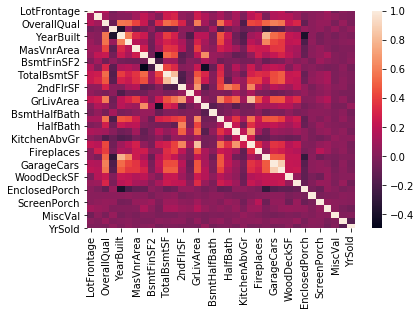

In [407]:
corr = df_num.corr()
sns.heatmap(corr)